# Dataset

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('always')

In [35]:
# load the final dataframe from data_prep 
df_fulldata = pd.read_csv('diabetic_data_df.csv')

In [36]:
# Load columns to use from data_prep
col2use = pd.read_csv('col2use.csv')
col2use = col2use['col2use'].tolist()

df_data = df_fulldata[col2use]

In [37]:
df_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,age_group,has_weight
0,1,41,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,1,...,0,0,0,0,0,0,0,1,10,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,0,0,0,1,20,0
3,2,44,1,16,0,0,0,7,0,1,...,0,0,0,0,0,0,0,1,30,0
4,1,51,0,8,0,0,0,5,0,1,...,0,0,0,0,0,0,0,1,40,0


In [38]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

#print ('OUTPUT_LABEL' in df_data.columns.tolist())

In [39]:
#split dataset 
# -> stratified split
# -> 80% train
#    -> k-fold (k=4)
# -> 20% test
#    -> confusion matrix
#    -> accuracy
#    -> sensitivity
#    -> recall

#X = df_data.values #input
#Y = df_fulldata['OUTPUT_LABEL'].values

Y_o_no  = np.where(df_fulldata['OUTPUT_LABEL'].values == 0)[0]
Y_o_yes = np.where(df_fulldata['OUTPUT_LABEL'].values == 1)[0]

class_names = {1:'yes', 0:'no'}
names = ['no', 'yes']

#original base
print ('==> Size classes:')
for c in np.unique(df_fulldata['OUTPUT_LABEL'].values):
    s = np.sum(df_fulldata['OUTPUT_LABEL'].values == c).astype(np.float)
    print ('\t{:4} [{:1}] => {:5} => {:3}'.format(class_names[c], c,\
                                                  s, round(s/len(df_fulldata['OUTPUT_LABEL'].values), 3)))
    
#stratified base
print ('==> Size stratified') #~50% yes 50%no
i_y_no = np.random.choice(range(0, len(Y_o_no)), len(Y_o_yes))
X = np.concatenate((df_data.values[Y_o_yes], df_data.values[Y_o_no[i_y_no]]), axis=0)
Y = np.concatenate((df_fulldata['OUTPUT_LABEL'].values[Y_o_yes], \
                    df_fulldata['OUTPUT_LABEL'].values[Y_o_no[i_y_no]]), axis=0)

for c in np.unique(Y):
    s = np.sum(Y == c).astype(np.float)
    print ('\t{:4} [{:1}] => {:5} => {:3}'.format(class_names[c], c, s, round(s/len(Y), 3)))

#split dataset: train and test
X_train, X_test, Y_train,  Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y) 

#normalized data
scaler  = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print ('==> Dataset split:')
print ('\ttrain => input={} | output={}'.format(X_train.shape, Y_train.shape))
print ('\ttest  => input={}  | output={}'.format(X_test.shape, Y_test.shape))


==> Size classes:
	no   [0] => 88029.0 => 0.886
	yes  [1] => 11314.0 => 0.114
==> Size stratified
	no   [0] => 11314.0 => 0.5
	yes  [1] => 11314.0 => 0.5
==> Dataset split:
	train => input=(18102, 143) | output=(18102,)
	test  => input=(4526, 143)  | output=(4526,)


# Methods

In [40]:
from sklearn.metrics import classification_report, accuracy_score, \
                            average_precision_score, f1_score, precision_score,\
                            recall_score, roc_auc_score, log_loss, confusion_matrix

def report(y_true, y_pred, prefix):
    accuracy = accuracy_score(y_true, y_pred)
    ap      = average_precision_score(y_true, y_pred)
    f1      = f1_score(y_true, y_pred)
    lloss   = log_loss(y_true, y_pred)
    prec    = precision_score(y_true, y_pred)
    recall  = recall_score(y_true, y_pred)
    auc     = roc_auc_score(y_true, y_pred)
    
    print ('{} Accuracy :{:3}'.format(prefix, accuracy))
    print ('{} AP:       {:3}'.format(prefix, ap))
    print ('{} F1-score :{:3}'.format(prefix, f1))
    print ('{} Log-Loss :{:3}'.format(prefix, lloss))
    print ('{} Precision:{:3}'.format(prefix, prec))
    print ('{} Recall   :{:3}'.format(prefix, recall))
    print ('{} AUC      :{:3}'.format(prefix, auc))
    
    return accuracy

def make_confusion_matrix(y_true, y_pred, names, normalized, prefix=''):
    
    title = 'Confusion Matrix'
    cm = confusion_matrix(y_true, y_pred)
     
    if normalized:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=names, 
           yticklabels=names,
           ylabel='True Label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
                                   rotation_mode='anchor')
    
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='green')#'white' if cm[i,j] > thresh else 'black')
    
    fig.tight_layout()
    plt.show()    

# Linear SVM

In [41]:
from sklearn.svm import LinearSVC

# penalty     = l2
# loss        = hinge
# dual        = False
# tol         = 1e-6
# C           = 1.0
# multi_class = ovr
# verbose     = 0
# random_state= 42
# max_iter    = 1e6
_linear_svm = LinearSVC(dual=False, tol=1e-7, random_state=42, max_iter=1e7)
linear_svm  = None

### training

In [42]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

print ('==> training Linear SVM:')
iteration = 0
best_acc  = 0
for itrain, ivalid in kfold.split(X_train, Y_train):
    print ('\t\033[94m iteration {}\033[0m'.format(iteration))
    
    #split dataset into train and valid, based on folds
    xi_train, xi_valid = X_train[itrain], X_train[ivalid]
    yi_train, yi_valid = Y_train[itrain], Y_train[ivalid]
    print ('\t\t train size: input= {} | output= {}'.format(xi_train.shape, yi_train.shape))
    print ('\t\t valid size: input= {} | output= {}'.format(xi_valid.shape, yi_valid.shape))
        
    #train
    _linear_svm.fit(xi_train, yi_train)
    
    #valid
    y_train_predicted = _linear_svm.predict(xi_train) 
    y_valid_predicted = _linear_svm.predict(xi_valid)
    
    #report
    print ('\t\t report train:')
    report(y_true=yi_train, y_pred=y_train_predicted, prefix='\t\t\t')
    print ('\t\t report valid:')
    acc = report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='\t\t\t')
    
    if acc > best_acc:
        best_acc = acc
        linear_svm = _linear_svm
        
        with open('models/svm/best_linear_svm_model.txt', 'w') as f:
            f.write(str(iteration))
    
    with open('models/svm/linear_svm_{}'.format(iteration), 'wb') as f:
        f.write(pickle.dumps(_linear_svm))
          
    iteration += 1

==> training Linear SVM:
	 iteration 0
		 train size: input= (13576, 143) | output= (13576,)
		 valid size: input= (4526, 143) | output= (4526,)
		 report train:
			 Accuracy :0.5304213317619328
			 AP:       0.5161228199406207
			 F1-score :0.5338208409506399
			 Log-Loss :16.21886327448712
			 Precision:0.5299840278786119
			 Recall   :0.5377136122569239
			 AUC      :0.5304213317619328
		 report valid:
			 Accuracy :0.5002209456473707
			 AP:       0.5001105221639371
			 F1-score :0.49755664149266987
			 Log-Loss :17.261954696158273
			 Precision:0.5002233139794551
			 Recall   :0.4949182501104728
			 AUC      :0.5002209456473707
	 iteration 1
		 train size: input= (13576, 143) | output= (13576,)
		 valid size: input= (4526, 143) | output= (4526,)
		 report train:
			 Accuracy :0.5290954625810254
			 AP:       0.5154078351461858
			 F1-score :0.5253545177815724
			 Log-Loss :16.264651637255977
			 Precision:0.5295614428977697
			 Recall   :0.5212139068945197
			 AUC      :0.52909546

### test

==> test Linear SVM
	 Report 
	 Accuracy :0.5019885108263368
	 AP:       0.5009979545858507
	 F1-score :0.5185818026484409
	 Log-Loss :17.200920351089717
	 Precision:0.5018602728400166
	 Recall   :0.5364560318161732
	 AUC      :0.5019885108263367


	 Normalized Confusion Matrix 


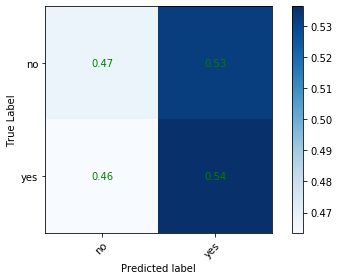

	 Unnormalized Confusion Matrix 


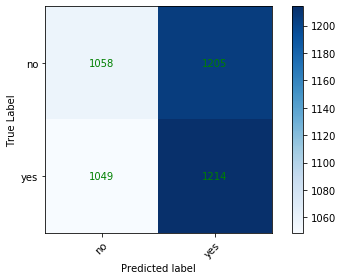

In [43]:
y_test_predicted = linear_svm.predict(X_test)

print ('==> test Linear SVM')
print ('\t\033[94m Report \033[0m')
_ = report(Y_test, y_test_predicted, prefix='\t')
print ('\n')
print ('\t\033[94m Normalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=True)
print ('\t\033[94m Unnormalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=False)

# Sigmoid SVM

In [44]:
from sklearn.svm import NuSVC

# nu     = 0.5
# kernel = sigmoid
# gamma  = 1/(n_features*X.var())
# coef0  = 0
# probability = True
# tol    = 1e-7
# verbose     = 0
# random_state= 42
# max_iter    = 1e7
# decision_function_shape = 'ovr'
_sigmoid_svm = NuSVC(kernel='sigmoid', gamma='scale', probability=True, tol=1e-7, max_iter=1e7, random_state=42)
sigmoid_svm  = None

### training

In [ ]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

print ('==> training Sigmoid SVM:')
iteration = 0
best_acc  = 0
for itrain, ivalid in kfold.split(X_train, Y_train):
    print ('\t\033[94m iteration {}\033[0m'.format(iteration))
    
    #split dataset into train and valid, based on folds
    xi_train, xi_valid = X_train[itrain], X_train[ivalid]
    yi_train, yi_valid = Y_train[itrain], Y_train[ivalid]
    print ('\t\t train size: input= {} | output= {}'.format(xi_train.shape, yi_train.shape))
    print ('\t\t valid size: input= {} | output= {}'.format(xi_valid.shape, yi_valid.shape))
        
    #train
    _sigmoid_svm.fit(xi_train, yi_train)
    
    #valid
    y_train_predicted = _sigmoid_svm.predict(xi_train) 
    y_valid_predicted = _sigmoid_svm.predict(xi_valid)
    
    #report
    print ('\t\t report train:')
    report(y_true=yi_train, y_pred=y_train_predicted, prefix='\t\t\t')
    print ('\t\t report valid:')
    acc = report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='\t\t\t')
    
    if acc > best_acc:
        best_acc = acc
        sigmoid_svm = _sigmoid_svm
        
        with open('models/svm/best_sigmoid_svm_model.txt', 'w') as f:
            f.write(str(iteration))
    
    with open('models/svm/sigmoid_svm_{}'.format(iteration), 'wb') as f:
        f.write(pickle.dumps(_sigmoid_svm))
          
    iteration += 1

==> training Sigmoid SVM:
	 iteration 0
		 train size: input= (13576, 143) | output= (13576,)
		 valid size: input= (4526, 143) | output= (4526,)


### test

In [ ]:
y_test_predicted = sigmoid_svm.predict(X_test)

print ('==> test Linear SVM')
print ('\t\033[94m Report \033[0m')
_ = report(Y_test, y_test_predicted, prefix='\t')
print ('\n')
print ('\t\033[94m Normalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=True)
print ('\t\033[94m Unnormalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=False)

# Poly SVM

In [ ]:
from sklearn.svm import NuSVC

# nu     = 0.5
# kernel = poly
# degree = 4
# gamma  = 1/(n_features*X.var())
# coef0  = 0
# probability = True
# tol    = 1e-7
# verbose     = 0
# random_state= 42
# max_iter    = 1e7
# decision_function_shape = 'ovr'
_poly_svm = NuSVC(kernel='poly', degree=4, gamma='scale', probability=True, tol=1e-7, max_iter=1e7, random_state=42)
poly_svm  = None

### training

In [ ]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

print ('==> training Poly SVM:')
iteration = 0
best_acc  = 0
for itrain, ivalid in kfold.split(X_train, Y_train):
    print ('\t\033[94m iteration {}\033[0m'.format(iteration))
    
    #split dataset into train and valid, based on folds
    xi_train, xi_valid = X_train[itrain], X_train[ivalid]
    yi_train, yi_valid = Y_train[itrain], Y_train[ivalid]
    print ('\t\t train size: input= {} | output= {}'.format(xi_train.shape, yi_train.shape))
    print ('\t\t valid size: input= {} | output= {}'.format(xi_valid.shape, yi_valid.shape))
        
    #train
    _poly_svm.fit(xi_train, yi_train)
    
    #valid
    y_train_predicted = _poly_svm.predict(xi_train) 
    y_valid_predicted = _poly_svm.predict(xi_valid)
    
    #report
    print ('\t\t report train:')
    report(y_true=yi_train, y_pred=y_train_predicted, prefix='\t\t\t')
    print ('\t\t report valid:')
    acc = report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='\t\t\t')
    
    if acc > best_acc:
        best_acc = acc
        poly_svm = _poly_svm
        
        with open('models/svm/best_poly_svm_model.txt', 'w') as f:
            f.write(str(iteration))
    
    with open('models/svm/poly_svm_{}'.format(iteration), 'wb') as f:
        f.write(pickle.dumps(_poly_svm))
          
    iteration += 1

### test

In [ ]:
y_test_predicted = poly_svm.predict(X_test)

print ('==> test Poly SVM')
print ('\t\033[94m Report \033[0m')
_ = report(Y_test, y_test_predicted, prefix='\t')
print ('\n')
print ('\t\033[94m Normalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=True)
print ('\t\033[94m Unnormalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=False)

# RBF SVM

In [ ]:
from sklearn.svm import NuSVC

# nu     = 0.5
# kernel = rbf
# gamma  = 1/(n_features*X.var())
# probability = True
# tol    = 1e-7
# verbose     = 0
# random_state= 42
# max_iter    = 1e7
# decision_function_shape = 'ovr'
_rbf_svm = NuSVC(kernel='rbf', gamma='scale', probability=True, tol=1e-7, max_iter=1e7, random_state=42)
rbf_svm  = None

### training

In [ ]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

print ('==> training Poly SVM:')
iteration = 0
best_acc  = 0
for itrain, ivalid in kfold.split(X_train, Y_train):
    print ('\t\033[94m iteration {}\033[0m'.format(iteration))
    
    #split dataset into train and valid, based on folds
    xi_train, xi_valid = X_train[itrain], X_train[ivalid]
    yi_train, yi_valid = Y_train[itrain], Y_train[ivalid]
    print ('\t\t train size: input= {} | output= {}'.format(xi_train.shape, yi_train.shape))
    print ('\t\t valid size: input= {} | output= {}'.format(xi_valid.shape, yi_valid.shape))
        
    #train
    _rbf_svm.fit(xi_train, yi_train)
    
    #valid
    y_train_predicted = _rbf_svm.predict(xi_train) 
    y_valid_predicted = _rbf_svm.predict(xi_valid)
    
    #report
    print ('\t\t report train:')
    report(y_true=yi_train, y_pred=y_train_predicted, prefix='\t\t\t')
    print ('\t\t report valid:')
    acc = report(y_true=yi_valid, y_pred=y_valid_predicted, prefix='\t\t\t')
    
    if acc > best_acc:
        best_acc = acc
        rbf_svm = _rbf_svm
        
        with open('models/svm/best_poly_svm_model.txt', 'w') as f:
            f.write(str(iteration))
    
    with open('models/svm/poly_svm_{}'.format(iteration), 'wb') as f:
        f.write(pickle.dumps(_rbf_svm))
          
    iteration += 1

### test

In [ ]:
y_test_predicted = rbf_svm.predict(X_test)

print ('==> test RBF SVM')
print ('\t\033[94m Report \033[0m')
_ = report(Y_test, y_test_predicted, prefix='\t')
print ('\n')
print ('\t\033[94m Normalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=True)
print ('\t\033[94m Unnormalized Confusion Matrix \033[0m')
make_confusion_matrix(y_true=Y_test, y_pred=y_test_predicted, names=['no', 'yes'], normalized=False)